In [1]:
from tensorflow.keras.layers import Conv1D, Conv2D, MaxPooling1D, MaxPooling2D, Flatten, Dense, Dropout
from sklearn.model_selection import train_test_split
from tqdm import tqdm
from tensorflow.keras.models import Sequential
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import TensorBoard, EarlyStopping, ModelCheckpoint, CSVLogger
from tensorflow.keras.layers import LSTM, GRU, Dense, Dropout, BatchNormalization
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
from keras.preprocessing.image import ImageDataGenerator
import seaborn as sns
import numpy as np
import os

In [2]:
# prompt: monta il disco

from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
# prompt: vorrei usare i CUDA, device 0

import tensorflow as tf

# Check if a GPU is available
if tf.config.list_physical_devices('GPU'):
  # Set the first available GPU as the default device
  tf.config.set_visible_devices(tf.config.list_physical_devices('GPU')[0], 'GPU')
  # Confirm that the device is set correctly
  print("Using device:", tf.config.list_physical_devices('GPU')[0].name)

else:
  # If no GPU is available, print a message
  print("No GPU available. Using CPU instead.")


Using device: /physical_device:GPU:0


In [4]:
# prompt: vorrei verificare la presenza di cuda attivi

# Check if a GPU is available
if tf.config.list_physical_devices('GPU'):
  # Print the number of available GPUs
  print(f"Number of available GPUs: {len(tf.config.list_physical_devices('GPU'))}")
  # Print the name of the first available GPU
  print(f"First available GPU: {tf.config.list_physical_devices('GPU')[0].name}")
else:
  # Print a message if no GPUs are available
  print("No GPUs available.")


Number of available GPUs: 1
First available GPU: /physical_device:GPU:0


In [5]:
loaded = np.load('/content/drive/MyDrive/Colab Notebooks/ASL_Detenction/X.npz')
# verifico le chiavi disponibili
print(loaded.files)
# access array
X = loaded['data']
print(X.shape)  # dovrebbe stampare (4921, 1662, 30)
print(type(X))
X = np.expand_dims(X, axis=-1)

['data']
(4921, 1662, 30)
<class 'numpy.ndarray'>


In [6]:
loaded = np.load('/content/drive/MyDrive/Colab Notebooks/ASL_Detenction/y.npz')
# verifico le chiavi disponibili
print(loaded.files)
# access array
y = loaded['data']
print(y.shape)  # dovrebbe stampare (4921, 58)
print(type(y))


['data']
(4921, 58)
<class 'numpy.ndarray'>


In [7]:
# Creare un oggetto ImageDataGenerator con tecniche di data augmentation
datagen = ImageDataGenerator(
    # rotation_range=10,                # Rotazione casuale delle immagini fino a 40 gradi
    width_shift_range=0.05,             # Traslazione orizzontale casuale delle immagini fino al 20%
    height_shift_range=0.05,            # Traslazione verticale casuale delle immagini fino al 20%
    #shear_range=0.2,                   # Trasformazione di taglio casuale
    zoom_range=0.1,                     # Zoom casuale delle immagini fino al 20%
    # horizontal_flip=True,             # Ribaltamento orizzontale casuale
    fill_mode='nearest'                 # Modalità di riempimento dei pixel vuoti dopo la trasformazione
)

In [8]:
# def training data and test data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [8]:
X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.15, random_state=42, stratify=y)
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.1765, random_state=42, stratify=y_temp)

In [9]:
# Generare nuove immagini augmented durante l'addestramento
datagen.fit(X_train)

# def CNN model
input_shape = (1662, 30, 1)
num_classes = 58

In [ ]:
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dense(num_classes, activation='softmax')
])


In [10]:
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Dropout(0.25),

    Conv2D(64, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Dropout(0.25),

    Conv2D(128, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Dropout(0.25),

    Flatten(),
    Dense(128, activation='relu'),
    BatchNormalization(),
    Dropout(0.5),

    Dense(num_classes, activation='softmax')
])

In [11]:
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [12]:
os.makedirs('/content/drive/MyDrive/Colab Notebooks/ASL_Detenction/logs', exist_ok=True)
os.makedirs('/content/drive/MyDrive/Colab Notebooks/ASL_Detenction/models', exist_ok=True)
path_logs = '/content/drive/MyDrive/Colab Notebooks/ASL_Detenction/logs'
path_models = '/content/drive/MyDrive/Colab Notebooks/ASL_Detenction/models'

In [13]:
def create_folder_for_training(number):
    log_f = os.path.join(path_logs, 'log_' + str(number), '')
    model_f = os.path.join(path_models, 'model_' + str(number))
    os.makedirs(log_f, exist_ok=True)
    os.makedirs(model_f, exist_ok=True)
    return log_f, model_f

In [14]:
log_f, model_f = create_folder_for_training(99)

In [15]:
# log
tensorboard_callback = TensorBoard(log_dir=log_f, histogram_freq=1)
training_log = os.path.join(log_f, 'train_log.csv')
csv_logger = CSVLogger(training_log, append=True)

In [16]:
# Training model
model.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['categorical_accuracy'])
early_stopping = EarlyStopping(monitor='loss', patience=10, restore_best_weights=True)
best_model_path = os.path.join(model_f, 'best_model.h5')
checkpoint = ModelCheckpoint(best_model_path, monitor='loss', save_best_only=True)


In [17]:
history = model.fit(X_train, y_train, epochs=200, batch_size=32, validation_data=(X_val, y_val), callbacks=[early_stopping, checkpoint, csv_logger, tensorboard_callback])

Epoch 1/200
108/108 [==============================] - ETA: 0s - loss: 3.8644 - categorical_accuracy: 0.0825

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


108/108 [==============================] - 20s 130ms/step - loss: 3.8644 - categorical_accuracy: 0.0825 - val_loss: 11.6013 - val_categorical_accuracy: 0.0203
Epoch 2/200
108/108 [==============================] - 13s 124ms/step - loss: 3.2837 - categorical_accuracy: 0.1609 - val_loss: 40.2380 - val_categorical_accuracy: 0.0081
Epoch 3/200
108/108 [==============================] - 12s 112ms/step - loss: 2.8220 - categorical_accuracy: 0.2585 - val_loss: 72.7868 - val_categorical_accuracy: 0.0027
Epoch 4/200
108/108 [==============================] - 14s 127ms/step - loss: 2.5410 - categorical_accuracy: 0.3070 - val_loss: 79.7635 - val_categorical_accuracy: 0.0135
Epoch 5/200
108/108 [==============================] - 13s 125ms/step - loss: 2.2874 - categorical_accuracy: 0.3616 - val_loss: 58.9362 - val_categorical_accuracy: 0.0095
Epoch 6/200
108/108 [==============================] - 12s 113ms/step - loss: 2.1002 - categorical_accuracy: 0.4211 - val_loss: 13.8532 - val_categorical_acc

In [18]:
# save best model
final_model_path = os.path.join(model_f, 'final_model.h5')
model.save(final_model_path)

In [19]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 1660, 28, 32)      320       
                                                                 
 batch_normalization (Batch  (None, 1660, 28, 32)      128       
 Normalization)                                                  
                                                                 
 max_pooling2d (MaxPooling2  (None, 830, 14, 32)       0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 830, 14, 32)       0         
                                                                 
 conv2d_1 (Conv2D)           (None, 828, 12, 64)       18496     
                                                                 
 batch_normalization_1 (Bat  (None, 828, 12, 64)       2

** Evaluation using Confusion Matrix and Accuracy **

In [20]:
y_pred = model.predict(X_test)

24/24 [==============================] - 0s 14ms/step


In [21]:
y_true = np.argmax(y_test, axis=1).tolist()
y_pred = np.argmax(y_pred, axis=1).tolist()

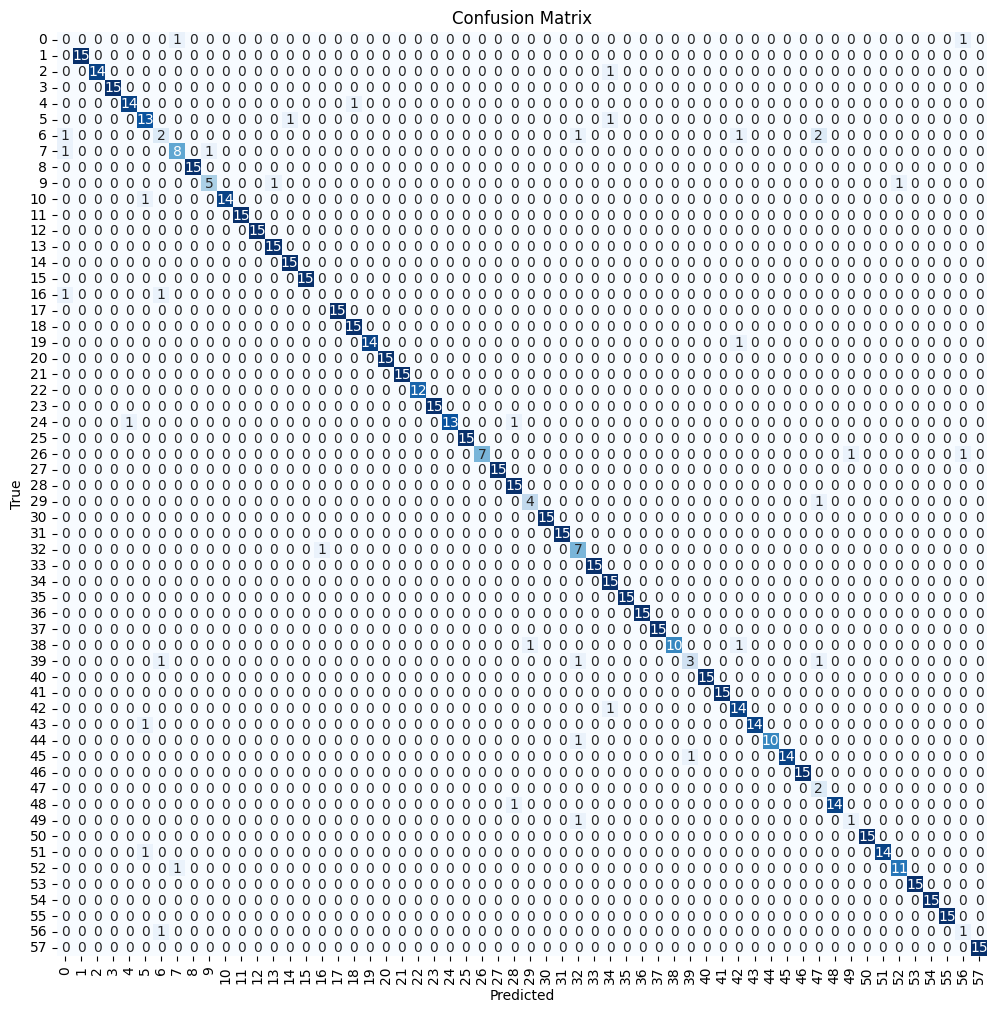

In [22]:
# calculate confusion matrix
cm = confusion_matrix(y_true, y_pred)

# show confusion matrix
plt.figure(figsize=(12, 12))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')

# save confusion matrix into file JPG
plt.savefig(model_f + '/confusion_matrix.jpg', format='jpg')
plt.show()
plt.close()

In [23]:
accuracy = accuracy_score(y_true, y_pred)
print("Accuracy:", accuracy)

Accuracy: 0.9472259810554804


In [24]:
# Evaluate model
score = model.evaluate(X_test, y_test, verbose=0)
print(f'Test loss: {score[0]} / Test accuracy: {score[1]}')

Test loss: 1.3981348276138306 / Test accuracy: 0.9472259879112244
